In [6]:
import pydpmd as dp
from pydpmd.plot import draw_particles_frame, create_animation, downsample, draw_circle
from pydpmd.utils import split_systems, join_systems
import matplotlib.pyplot as plt
import numpy as np
import os
from mode_resources import *
from system_building_resources import *
import subprocess
import h5py
from collections import defaultdict
from correlation_functions import compute_stress_acf, compute_einstein_helfand_stress_acf

def get_relaxation_time(f, t):
    tau = np.interp(1 / np.e, f[::-1], t[::-1])
    if not np.min(f) < 1 / np.e:
        return np.nan
    return tau

def calc_acf(Y, t):
    shape = [len(t) - 1]
    windows = np.zeros(shape)
    shape.extend(list(Y[0].shape))
    results = np.zeros(shape)
    for i in tqdm(range(1, len(t))):
        results[i - 1] = np.sum(Y[i:] * Y[:-i], axis=0) / (t[i:].size)
        windows[i - 1] = i
    return results, windows

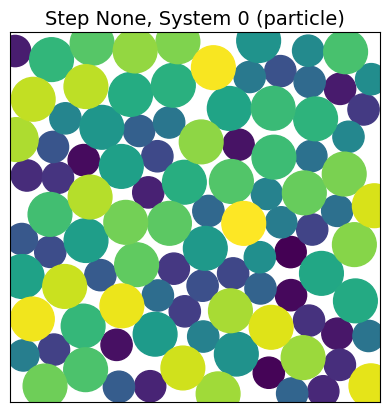

In [7]:
root = '/home/mmccraw/dev/data/11-01-25/'
data = dp.data.load(os.path.join(root, 'jamming/disk-large/jamming/'), location=["final", "init"])
draw_particles_frame(None, plt.gca(), data, 0, True, 'particle', 'viridis', 'final')

In [10]:
data_new = []
temperature = 1e-5
for delta_phi in -np.logspace(-2, np.log10(0.2), 10):
    data = dp.data.load(os.path.join(root, 'jamming/disk-large/jamming/'), location=["final", "init"])
    del data.final.arrays['hessian_xx'], data.final.arrays['hessian_xy'], data.final.arrays['hessian_yx'], data.final.arrays['hessian_yy'], data.final.arrays['pair_dist'], data.final.arrays['pair_forces'], data.final.arrays['pair_ids']
    data.add_array(np.arange(data.n_systems()), 'original_system_id')
    data.add_array(np.ones(data.n_systems()) * delta_phi, 'delta_phi')
    data.add_array(np.ones(data.n_systems()) * temperature, 'target_temp')
    data.scale_to_packing_fraction(data.packing_fraction + delta_phi)
    data.set_velocities(temperature, np.random.randint(0, 1e9))
    data_new.append(data)
data_new = join_systems(data_new)

In [11]:
dynamics_path = os.path.join(root, 'hp-dynamics')

In [61]:
dynamics_path = os.path.join(root, 'hp-dynamics')
data_new.set_neighbor_method(NeighborMethod.Cell)
set_standard_cell_list_parameters(data_new, 0.3)
data_new.save(dynamics_path)

n_steps = 1e5
save_freq = 1e0
dt = 1e-2

subprocess.run([
    os.path.join("/home/mmccraw/dev/dpmd/build/", "nve_disk_pbc_final"),
    dynamics_path,
    dynamics_path,
    str(n_steps),
    str(save_freq),
    str(dt),
], check=True)

Running for 100000 steps
Step 0
Step 10000
Step 20000
Step 30000
Step 40000
Step 50000
Step 60000
Step 70000
Step 80000
Step 90000
Done


CompletedProcess(args=['/home/mmccraw/dev/dpmd/build/nve_disk_pbc_final', '/home/mmccraw/dev/data/11-01-25/hp-dynamics', '/home/mmccraw/dev/data/11-01-25/hp-dynamics', '100000.0', '1.0', '0.01'], returncode=0)

In [62]:
final = dp.data.load(dynamics_path, location=['final', 'init'], load_trajectory=True)
final_partial = dp.data.load(dynamics_path, location=['final', 'init'], load_trajectory=True, load_full=False)
temp = np.mean(final.trajectory.temperature, axis=0)
pressure = np.mean(final.trajectory.pressure, axis=0)
original_system_id = final.original_system_id.copy()
delta_phi = final.delta_phi.copy()
target_temp = final.target_temp.copy()
stress_acf, t = compute_stress_acf(final_partial, subtract_mean_stress=True)
he_stress_acf, t = compute_einstein_helfand_stress_acf(final_partial)

stress = np.array(
    [
        np.column_stack(
            [final.trajectory[i].stress_tensor_total_x, final.trajectory[i].stress_tensor_total_y]
            ) for i in range(final.trajectory.num_frames())
    ]
)

Binned accumulation: 100%|██████████| 3958381/3958381 [00:14<00:00, 263991.75it/s] 


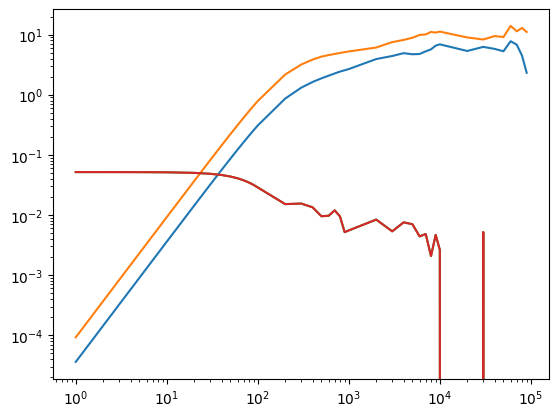

In [64]:
plt.plot(t, he_stress_acf[:, 1, 0])
plt.plot(t, he_stress_acf[:, 2, 0])
plt.plot(t, stress_acf[:, 1, 0])
plt.plot(t, stress_acf[:, 2, 0])
plt.xscale('log')
plt.yscale('log')

In [65]:
def one_time_stress_acf(stress_x, stress_y):
    acf = []
    t = []
    for i in tqdm(range(1, stress_x.shape[0] - 1)):
        acf.append([
            stress_x[i, :, 0] * stress_x[0, :, 0],
            stress_x[i, :, 1] * stress_x[0, :, 1],
            stress_y[i, :, 0] * stress_y[0, :, 0],
            stress_y[i, :, 1] * stress_y[0, :, 1],
        ])
        t.append(i)
    return np.array(acf), np.array(t)

def one_time_einstein_helfand_stress_acf(vel, pos, system_offset, mass):
    acf = []
    t = []
    for i in tqdm(range(1, vel.shape[0] - 1)):
        acf.append(0.5 * np.add.reduceat(
            np.array([
                vel[i, :, 0] * pos[i, :, 0] - vel[0, :, 0] * pos[0, :, 0],
                vel[i, :, 0] * pos[i, :, 1] - vel[0, :, 0] * pos[0, :, 1],
                vel[i, :, 1] * pos[i, :, 0] - vel[0, :, 1] * pos[0, :, 0],
                vel[i, :, 1] * pos[i, :, 1] - vel[0, :, 1] * pos[0, :, 1]
            ]) * mass,
            system_offset[:-1],
            axis=1
        ) ** 2)
        t.append(i)
    return np.array(acf), np.array(t)

stress_one, t_one = one_time_stress_acf(
    final.trajectory.stress_tensor_total_x,# - np.mean(final.trajectory.stress_tensor_total_x, axis=0),
    final.trajectory.stress_tensor_total_y# - np.mean(final.trajectory.stress_tensor_total_y, axis=0)
)
eh_stress_one, t_one = one_time_einstein_helfand_stress_acf(final.trajectory.vel, final.trajectory.pos, final.system_offset, final.mass)

100%|██████████| 99998/99998 [00:07<00:00, 13881.43it/s]


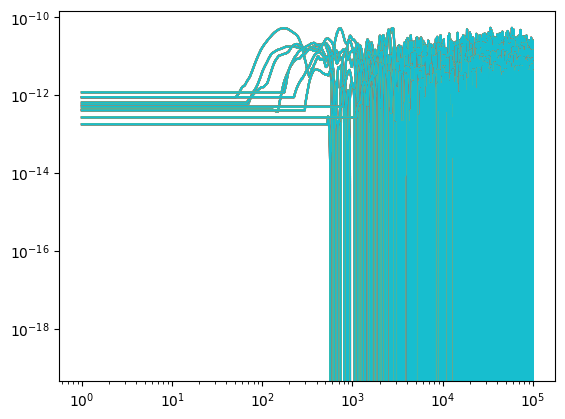

In [91]:
for dphi in final.delta_phi:
    mask = final.delta_phi == dphi
    s = np.mean(stress_one[..., mask], axis=-1)
    plt.plot(t_one, s[:, 2])
plt.xscale('log')
plt.yscale('log')
plt.show()

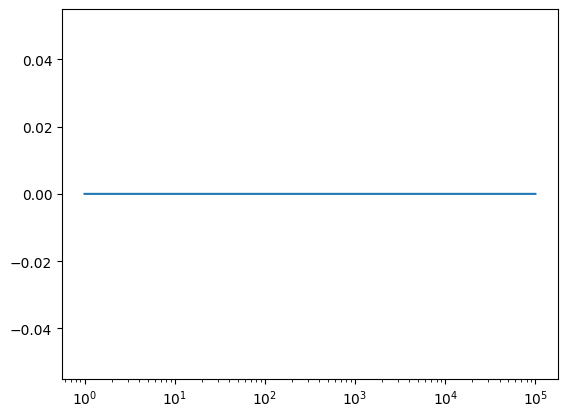

In [44]:
plt.plot(t_one, stress_one[:, 1, 0])
# plt.plot(t_one, eh_stress_one[:, 1, 0])
plt.xscale('log')
# plt.yscale('log')

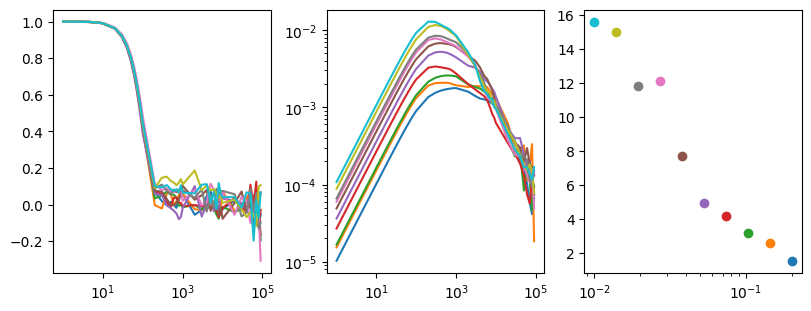

In [51]:
i = 0
fig, ax = plt.subplots(1, 3, figsize=(8, 3), constrained_layout=True)
mask = original_system_id == 9
for dphi in np.unique(delta_phi[mask]):
    mask2 = (delta_phi == dphi) & mask
    S = stress_acf[..., mask2].squeeze()
    G0 = S[0, i]
    tau = get_relaxation_time(S[:, i] / G0, t)
    eta = tau * G0
    ax[0].plot(t, S[:, i] / G0)
    S = he_stress_acf[..., mask2].squeeze()
    ax[1].plot(t, S[:, i] / t)
    ax[2].scatter(-dphi, eta)
# plt.yscale('log')
for a in ax:
    a.set_xscale('log')
ax[1].set_yscale('log')
plt.show()

In [46]:
sid = 5
window = 100
stress = np.concatenate((final.trajectory.stress_tensor_total_x, final.trajectory.stress_tensor_total_y), axis=-1)
# stress -= np.mean(stress, axis=0)
time = np.arange(stress.shape[0])
stress_sm_1 = np.convolve(stress[:, sid, 1], np.ones(window), mode='valid') / window
time_1 = np.arange(stress_sm_1.shape[0])
stress_sm_2 = np.zeros(stress[:, sid, 1].size // window)
time_2 = np.zeros(stress_sm_2.size)
for i in range(len(stress_sm_2)):
    stress_sm_2[i] = np.mean(stress[i * window:(i + 1) * window, 0, 1], axis=0)
    time_2[i] = np.mean(time[i * window:(i + 1) * window])

stress_acf_0, t_0 = calc_acf(stress[:, sid, 1], time)
stress_acf_1, t_1 = calc_acf(stress_sm_1, time_1)
stress_acf_2, t_2 = calc_acf(stress_sm_2, time_2)

100%|██████████| 999/999 [00:00<00:00, 340493.23it/s]


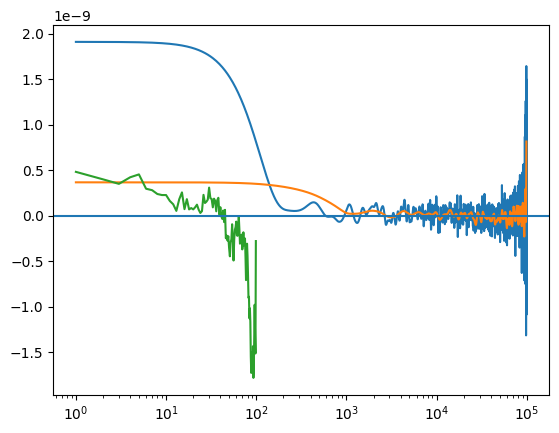

In [ ]:
plt.plot(t_0, stress_acf_0)
plt.plot(t_1, stress_acf_1)
plt.plot(t_2, stress_acf_2)
plt.axhline(0)
plt.xscale('log')

In [ ]:
dynamics_path = os.path.join(root, 'dynamics')


In [38]:
desired_frames = 100
steps_to_animate = downsample(final, desired_frames)

output_path = "anim.gif"

# Create the animation using the downsampled steps
create_animation(
    update_func=draw_particles_frame,
    frames=steps_to_animate,
    filename=output_path,
    fps=15,
    bitrate=3000,
    data=final,
    system_id=5,
    use_pbc=True,
    which='particle',
    cmap_name='grey',
    id_scale=1.1
)

Creating animation:   4%|▍         | 4/100 [00:00<00:03, 31.94it/s]

Saving animation to anim.gif...


Creating animation: 101it [00:04, 24.47it/s]                         

Animation saved successfully!
